In [1]:
import pandas as pd
import numpy as np

### Aufgabe 1: Decision Trees in Scikit-learn, Datenverarbeitung mit pandas

#### a) Einlesen des Diabetes-Datensatzes

Lesen Sie den Diabetest-Datensatz (vgl. Moodle) in einen pandas DataFrame ein. Dieser enthält verschiedene numerische Features, mit denen ein Entscheidungsbaum zur Vorhersage, ob ein Patient an Diabetes erkrankt ist oder nicht (Spalte Outcome), trainiert werden soll.

Verwenden Sie dazu die Funktion **read_csv**. Verschaffen Sie sich mittels der Funktion **head** einen Überblick über den Datensatz.

In [2]:
data = pd.read_csv('diabetes.csv').dropna().drop_duplicates()
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### b) Train-Test-Split

Splitten Sie den Datenatz in einen Trainingsdatensatz und einen Testdatensatz, sodass der Testdatensatz 30% der Samples enthält. Verwenden Sie dazu die Funktion **train_test_split** aus dem Modul sklearn.model_selection

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.3)

#### b) Datenvorbereitung

Legen Sie neue Variablen y_train und y_test an, in denen die Labels gespeichert werden sollen. Diese befinden sich in der Spalte **Outcome**. Löschen Sie diese anschließend aus X_train und X_test.

In [4]:
y_train = train_data.loc[:, ['Outcome']]    #Ergebnis Trainingsdaten
y_test = test_data.loc[:, ['Outcome']]  #Ergebnis Testdaten

X_train = train_data.drop(columns=['Outcome'])  #Daten zum Modeltrainieren
X_test = test_data.drop(columns=['Outcome'])    #Daten zum Modeltesten

In [5]:
X_test.shape

(231, 8)

#### c) Training eines Entscheidungsbaums

Fitten Sie einen DecisionTreeClassifier aus Scikit-learn mit den Parametern max_depth=10 und min_samples_leaf = 1

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=69, min_samples_leaf=5,max_depth=5)

clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=69)

#### d) Modellvalidierung

Validieren Sie das resultierende Modell, indem Sie den Anteil der falsch klassifizierten Datensätze im Trainings- und im Testdatensatz berechnen. Wie erklären Sie Ihre Beobachtung? Trainieren Sie den Baum erneut mit den Parametern *max_depth=3* und *min_samples_leaf=5* und wiederholen Sie die Berechnung der Anteile der falsch klassifizierten Datensätze.

In [7]:
from sklearn import metrics
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7489177489177489


#### e) Visualisierung

Visualisieren Sie den Baum mit graphviz, indem Sie den folgenden Code ausführen. Ggf. müssen Sie zuerst durch Eingabe von *conda install python-graphviz* im Anaconda Prompt das Paket graphviz installieren und es zum Such-Pfad hinzufügen.

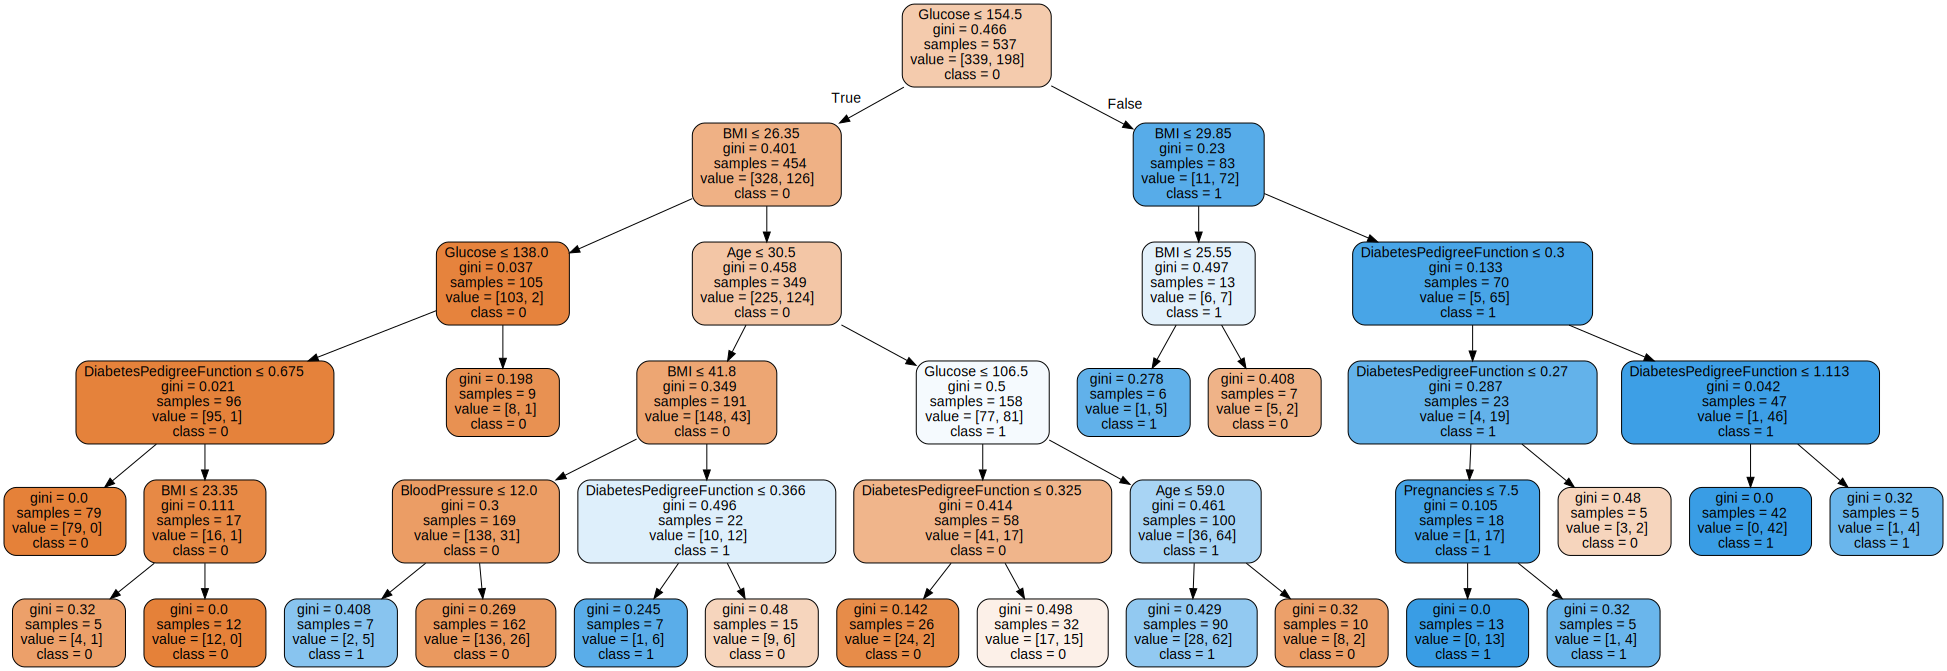

In [10]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None) 
 
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=train_data.columns[:-1],  
                      class_names=['0','1'],  
                      filled=True, rounded=True,  
                      special_characters=True) 

graph = graphviz.Source(dot_data)
graph

### Aufgabe 2: Implementierung eines Decision Trees

#### a) Berechnung der Gini impurity

Schreiben Sie eine Funktion namens **gini_index**, die die (mit der Datensatzlänge) gewichtete Gini impurity für mehrere gegebene Datensätze berechnet. Die Datensätze werden in einer Liste namens groups übergeben und enthalten jeweils die Zielvariable (Klassenzuordnung) in der letzten Spalte. Die möglichen Klassen/Zielfunktionswerte werden in einer Liste namens classes übergeben.

Vorgehen:
- Berechnen Sie die Gesamtanzahl aller Datensätze in groups
- Iterieren Sie über die Datensätze in groups und berechnen Sie für jeden Datensatz die Anteile $p_1,\ldots,p_n$, mit der jede der Klassen $C_1,\ldots,C_n$ vorkommt.
- Berechnen Sie daraus die Gini impurity für jeden Datensatz: $Gini(X)= 1-\sum_{i=1}^n p_i^2$
- Gewichten Sie die erhaltenen Werte anhand der Datensatzlängen



In [42]:
def gini_index(groups, classes):
    """
    returns the weighted gini impurity of the datasets contained in groups with respect to a target variable. 
    
    Parameters:
        groups (list): list of pandas dataframes representing the datasets. The last column of each dataframe contains the target variable
        classes (list): list of all possible class values
        
    Returns:
        gini index (float) of the data sets contained in groups with respect to the target values contained in classes
    """
    
    num_dataset = 0
    p_sum = 0
    for dataframe in groups:
        num_dataset += dataframe.count().iloc[0]
        for key in classes:
            p_sum += (dataframe['t'].value_counts().iloc[key]/num_dataset)**2     
        
    Gini = 1 - p_sum
    return Gini

    

#### b) Test der Funktion gini_index

Testen Sie die Funktion gini_index anhand der folgenden beiden DataFrames. Berechnen Sie zunächst manuell das Ergebnis.

In [38]:
X1 = pd.DataFrame({"a":[1,2,3,0,-1,2,1], "t": [0,1,0,0,2,0,2]})
X2 = pd.DataFrame({"b": [0,-1,0,0,1], "t": [0,1,0,0,2]})

In [43]:
gini_index( [X1,X2],[0,1,2])

0.49503968253968256

#### c) Binärer Split eines Datensatzes

Scheiben Sie eine Funktion namens **split_data**, die den Split eines Datensatzes an einer gegebenen Spalte für einen  gegebenen Schwellwert realisiert.

In [29]:
def split_data(col, thresh, X):
    """
    Binary split of the dataset X by checking if X[col]<thresh or X[col]>= thresh, respectively.
    All columns of X are assumed to be numeric.
    
    Parameters:
        col: name of the split column
        thresh: threshold for the split
        X (pandas DataFrame): data set to be split
        
    Returns:
        X_left, X_right (pandas DataFrames): data samples resulting from the split
    """
    if X['col'] < thresh:
        X_left = X.iloc[:,:col]
        X_right = X.iloc[col:,:]
    
    return X_left, X_right

#### d) Split eines Datensatzes

Schreiben Sie eine Funktion namens **get_split**, die für einen Datensatz X (gegeben als DataFrame) ein Attribut und einen Schwellwert für den (binären) Split bestimmt, indem die gewichtete Gini impurity minimiert wird. Die Zielfunktionswerte befinden sich in der letzten Spalte von X und X habe ausschließlich numerische Spalten. Die Funktion soll den Spaltennamen des Attributs, den Schwellwert, den Wert für die gewichtete Gini impurity und die beiden aus dem Split resultierenden Datensätze zurückgeben.

In [44]:
def get_split(X):
    """
    Determines the split column and threshold by minimizing (weighted) Gini impurity
    For each column, all possible values are considered as split threshold, and the column/value
    resulting in the split with the lowest Gini impurity is returned.
    
    Parameters:
        X (pandas DataFrame): training data containing the target values in the last column
    
    Returns:
        col_opt: name of the split column
        thresh_opt: split threshold
        gini_opt: weighted Gini impurity associated with the split
        g_left, g_right (pandas DataFrames): subsamples of X resulting from the split
    
    """
    
    min_impurity = 1
    min_column = 0
    thresh = 69
     
    
    for column in X.columns:
        X_left, X_right = split_data(column, thresh, X)
        curr_impurity = gini_index([X_left, X_right], X.colums)
        if curr_impurity < min_impurity:
            min_impurity = curr_impurity
            min_column = column
            
    return min_column, thresh, min_impurity, split_data(min_column, thresh, X)

#### e) Implementierung eines Decision Trees 

Im folgenden ist eine rekursive Node-Klasse und eine Decision-Tree-Klasse basierend auf den oben geschriebenen Funktionen realisiert worden. Vollziehen Sie den Code nach und vervollständigen Sie die Methode **predict**.

In [ ]:
class Node:
    """
    A recursive node class for building a binary decision tree based on training data having numeric features
    """
    
    def __init__(self,  data):
        self.data = data
        self.split_column = None
        self.thresh = np.inf
        self.gini = np.inf
        self.left_child = None
        self.right_child = None
        self.prediction = None
        self.class_probabilities = None
        
    def to_terminal(self):
        """
        mark the current node as a leaf (=terminal node)
        the prediction associated with this leaf is the most frequent class in the leaf
        the class probabilities associated with the leaf are given by the relative frequencies of the classes in the leaf
        """
        
        self.prediction = self.data.iloc[:,-1].value_counts().idxmax()
        self.class_probabilities = self.data.iloc[:,-1].value_counts(normalize=True).sort_index()
    
    def split(self, max_depth, min_samples_leaf, depth):
        """
        This function function is used to recursively build the decision tree. In each split, the split attribute is determined 
        by minimizing the (weighted) Gini impurity for the subsamples resulting from the split.
        """
        
        #determine split attribute and samples resulting from this split
        self.split_column, self.thresh, self.gini, data_left, data_right = get_split(self.data)
        
        if data_left.shape[0]==0 or data_right.shape[0]==0:
            self.to_terminal()
            return
        else:       
            #pre pruning
            if depth >= max_depth:
                self.to_terminal()
                return 
            
            if data_left.shape[0] < min_samples_leaf:
                self.to_terminal()
                return
            else:
                #create new left node and call split method recursively
                self.left_child = Node(data_left)
                self.left_child.split(max_depth, min_samples_leaf, depth+1)
                   
            #pre pruning
            if data_right.shape[0]<min_samples_leaf:
                self.to_terminal()
                return
            else:
                #create new right node and call split method recursively
                self.right_child = Node(data_right)
                self.right_child.split(max_depth, min_samples_leaf, depth+1)
        self.data = None
           

    def predict(self, row): 
        """
        For a given sample, recursively navigate through the tree to find the leaf node to which it belongs. Then, return the class 
        associated with the leaf node.
        
        Parameters: 
            row (array-like): query point
            
        Returns:
            predicted class for query point row
        """
        
        #TODO

    def predict_proba(self, row, classes):
        """
        For a given sample named row, recursively navigate through the tree to find the leaf node to which it belongs. 
        Then, return the class probabilities associated with the leaf node.
        """
        
        if self.left_child is None or self.right_child is None:
            return self.class_probabilities.reindex(classes, fill_value=0.0).values
        else:   
            if row[self.split_columns]< self.thresh:
                return self.left_child.predict_proba(row, classes)
            else:
                return self.right_child.predict_proba(row, classes)
  
        
    def print_node(self, depth=0):
        """
        Print decisions for the subtree associated with the current node
        """
        
        if self.prediction is not None:
            print('%s[%s]' % ((depth*' ', self.prediction)))
        else:
            print('%s X[%s]< %.3f' % ((depth*' ', self.split_column, self.thresh)))
            self.left_child.print_node(depth+1)
            self.right_child.print_node(depth+1)
    
    
    def print_node_dot(self, depth = 0, label='0', s=''):
        """
        Print info in DOT graph description languange for visualization with graphviz
        """
        
        
        if self.prediction is not None:
            s_leaf = label+ ' [label=<class: %d<br/>gini=%.3f>] ;' % (self.prediction, self.gini) 
            return s_leaf
        else:
            s_node = label+ ' [label=<X[%s]&lt;%.3f<br/>gini=%.3f>] ;' % (self.split_column, self.thresh, self.gini)
            s_node_left = self.left_child.print_node_dot(depth+1, label+'0', s)
            s_node_right = self.right_child.print_node_dot(depth+1, label+'1', s)
           
            s_edge_left = label+ '->' +label+'0 [labeldistance=2.5, labelangle=45, headlabel="True"];'
            s_edge_right = label+ '->'+label+'1 [labeldistance=2.5, labelangle=-45, headlabel="False"];'
            
            return s + s_node+ "\n" + s_node_left+ "\n" + s_node_right+ "\n" + s_edge_left+ "\n" + s_edge_right
            



In [ ]:
class DecisionTree:
    """
    Binary Decision Tree for datasets having continuous features
    """
        
    def __init__(self, max_depth, min_samples_leaf):
        self.root = None
        self.classes = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf 
        
    def fit(self, data):
        """
        construct the decision tree using the data set data by calling the splid method 
        of the node class on the root node
        """
        
        self.root = Node(data)
        self.classes = data.iloc[:,-1].unique()
        self.root.split(self.max_depth, self.min_samples_leaf, 0)
    
    def predict(self, X):
        """
        Predict classes for all samples in X
        """
        return X.apply(self.root.predict, axis=1)
    
    def print_tree(self):
        """
        Print decisions of the decision tree
        """
        self.root.print_node()
    
    def print_tree_graphviz(self):
        """
        Print dot data associate with the decision tree to visualize it with graphviz
        """
        
        s1="""digraph Tree {
node [shape=box, style="filled, rounded", fillcolor="#e58139ff", fontname=helvetica] ;
edge [fontname=helvetica] ;"""
        s2 = """}"""
        return s1+self.root.print_node_dot(0)+s2
    
    def predict_proba(self, X):
        """
        Predict class probabilities for all samples contained in X
        """
        
        return X.apply(self.root.predict_proba, args=(self.classes,), axis=1)

#### f) Test der Decision Tree - Klasse

Testen Sie die Decision Tree Klasse am Beispiel des Iris-Datensatzes, indem Sie den folgenden Code ausführen.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

In [ ]:
X = pd.DataFrame(np.concatenate((iris.data, iris.target.reshape(150,1)), axis=1))
X_train, X_test = train_test_split(X, test_size = 0.3)

In [ ]:
tree = DecisionTree(2,5)
tree.fit(X_train)

In [ ]:
yhat = tree.predict(X_test)

In [ ]:
yhat.head()

In [ ]:
sum(yhat == X_test.iloc[:,-1])/len(yhat)

In [ ]:
tree.print_tree()

In [ ]:
dot_data = tree.print_tree_graphviz()
import graphviz
graph = graphviz.Source(dot_data)
graph